In [3]:
import numpy as np
from cosmoTransitions.tunneling1D import SingleFieldInstanton
from cosmoTransitions import generic_potential_Gegenbauer
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc
from scipy.special import gegenbauer
from scipy.special import eval_gegenbauer
from scipy.special import roots_gegenbauer



%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size

label_size=20
thick_size=20



####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
gtab = np.loadtxt( 'standardmodel2018.txt' )[::20]
g_star=interpolate.interp1d(gtab[::,0], gtab[::,1], kind='cubic')
g_sstar=interpolate.interp1d(gtab[::,0], gtab[::,3], kind='cubic')


def Hubble_radiation(T):
    """Hubble rate (squared) coming from radiation dof"""
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared

def Gamma_Hubble4(S,T):
    """Nucleation probability per Hubble volume, including matter contribution. 
    Integrand in formula (2.2) 1809.08242 """
    Gamma1=T**4*np.exp(-S/T)*np.sqrt((S/2/np.pi/T))**(3)
    return Gamma1


####MY FUNCTIONS START HERE      

def GBpotential(Ngb,n,z):
    lam=(Ngb-1)/2
    x=np.cos(z)
    return eval_gegenbauer(n,lam,x)

def GBpotential_roots(Ngb,n):
    """Return the roots of the Gegenbauer polynomial"""
    lam=(Ngb-1)/2
    output=roots_gegenbauer(n,lam)[0]
    return sorted(np.arccos(output[output>0]))
                 

def findGBminima(Ngb,n,roots_list):
    "Find the all minima of the Gegenbauer polynomial between 0 and pi/2"
    fun=lambda z:GBpotential(Ngb,n,z)
    output=[]
    for i in range(len(roots_list)):
        if 2*i+1==len(roots_list) or 2*i==len(roots_list):
            break
        solmin=optimize.minimize_scalar(fun,bounds=(roots_list[2*i],roots_list[2*i+1]),method="bounded",options={"disp":False})
        output.append(solmin.x)
    return np.array(output)

def whole_program(X,Ngb,n):
    """This function is used to find the initial conditions that yield correct minimization conditions"""
    roots=GBpotential_roots(Ngb,n)
    vacua_list=findGBminima(Ngb,n,roots)
    mass,vev=np.asarray(X)
    f=vev/vacua_list[0]
    fun_tree=lambda h :GBpotential(Ngb,n,h/f)
    DG=misc.derivative(fun_tree, x0=vev, n=1)
    D2G=misc.derivative(fun_tree, x0=vev, n=2)
    const=mass**2/D2G 
    def V_full(h):
        DG=misc.derivative(fun_tree, x0=h, n=1)
        D2G=misc.derivative(fun_tree, x0=h, n=2)
        Mh2=const*D2G
        MG2=const*DG/np.tan(h/f)/f
        VCW=Mh2**2*(np.log(np.sqrt(Mh2**2)/f**2)-1/2)
        VCW+=(Ngb-1)*MG2**2*(np.log(np.sqrt(MG2**2)/f**2)-1/2)
        VCW*=1/64/np.pi**2
        return const*fun_tree(h)+VCW    
    hmin=optimize.fmin(V_full,x0=vev,disp=False)[0]
    dV=misc.derivative(V_full, x0=hmin, n=1)
    d2V=misc.derivative(V_full, x0=hmin, n=2)
    return 1*abs(d2V**.5-mh)**2+1*abs(hmin-v)**2


def verify_program(X,Ngb,n):
    """This function spits out the confinement scale f and the multiplicative constant of the 
    Gegenbauer polynomial"""
    roots=GBpotential_roots(Ngb,n)
    vacua_list=findGBminima(Ngb,n,roots)
    mass,vev=np.asarray(X)
    f=1.*vev/vacua_list[0]
    fun_tree=lambda h :GBpotential(Ngb,n,h/f)
    DG=misc.derivative(fun_tree, x0=vev, n=1)
    D2G=misc.derivative(fun_tree, x0=vev, n=2)
    const=mass**2/D2G 
    def V_full(h):
        DG=misc.derivative(fun_tree, x0=h, n=1)
        D2G=misc.derivative(fun_tree, x0=h, n=2)
        Mh2=const*D2G
        MG2=const*DG/np.tan(h/f)/f
        VCW=Mh2**2*(np.log(np.sqrt(Mh2**2)/f**2)-1/2)
        VCW+=(Ngb-1)*MG2**2*(np.log(np.sqrt(MG2**2)/f**2)-1/2)
        VCW*=1/64/np.pi**2
        return const*fun_tree(h)+VCW    
    hmin=optimize.fmin(V_full,x0=vev,disp=False)[0]
    dV=misc.derivative(V_full, x0=hmin, n=1)
    d2V=misc.derivative(V_full, x0=hmin, n=2)
    print("Best approximation is, v=",hmin,", mh=",d2V**.5)
    return f, const

def kappa(xi_w,alpha):
    """
    Fit for the efficiency factor 
    """
    c_s         = 1./np.sqrt(3.)
    #kappa_A     = xi_w**1.2 * 6.9*alpha/(1.39-0.0037*np.sqrt(alpha)+alpha)
    kappa_A     = xi_w**1.2 * 6.9*alpha/(1.36-0.037*np.sqrt(alpha)+alpha)
    #kappa_B     = alpha**0.4/(0.0017+(0.997+alpha)**0.4)
    kappa_B     = alpha**0.4/(0.017+(0.997+alpha)**0.4)
    #kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98)+alpha)
    kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98+alpha))
    #kappa_D     = alpha/(0.75+0.085*np.sqrt(alpha)+alpha)
    kappa_D     = alpha/(0.73 + 0.083*np.sqrt(alpha)+alpha)
    delta_kappa = -0.9*np.log10(np.sqrt(alpha)/(1.+np.sqrt(alpha)))
    xi_w_J      = (np.sqrt(2./3.*alpha+alpha**2)+1./np.sqrt(3.))/(1.+alpha)

    if xi_w < c_s:
    # deflagration
        return c_s**2.2 * kappa_A * kappa_B / ( (c_s**2.2 - xi_w**2.2 )*kappa_B + xi_w * c_s**1.2 * kappa_A )
    elif xi_w < xi_w_J:
    # hybrid
        return (
            kappa_B
            + (xi_w -c_s)*delta_kappa
            + (xi_w-c_s)**3/(xi_w_J-c_s)**3 * ( kappa_C - kappa_B - (xi_w_J-c_s)*delta_kappa )
        )
    else:
        # detonation
        return (xi_w_J-1.)**3 * (xi_w_J/xi_w)**2.5 * kappa_C * kappa_D /(
            ( (xi_w_J-1.)**3 - (xi_w-1.)**3 ) * xi_w_J**2.5 * kappa_C
            + (xi_w-1.)**3 * kappa_D)



LISA_sens = np.loadtxt( 'PLS_ESACallv1-2_04yr.txt' )[::20]
def GW_signal(Temp,alpha,beta,vel):
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta ##eqn. (7.5)
    f_sw=2.6*1e-5/HR*(Temp/100)*(g_star(Temp)/100)**(1/6) ##eqn. (7.3)
    Sw = lambda f: (f/f_sw)**3*(4/7 + 3/7*(f/f_sw)**2)**(-7/2) ##eqn. (7.2)
    Uf=np.sqrt(3/4*alpha/(1+alpha)*kappa(vel,alpha))##eqn. (7.4)
    tauH = HR/Uf ##eqn. (7.4)
    prefactor=4.13*1e-7*HR*(1-1/np.sqrt(1+2*tauH))*(kappa(vel,alpha)*alpha/(1+alpha))**2 ##eqn. (7.1)
    Omega=lambda f: prefactor*(100/g_star(Temp))**(1/3)*Sw(f) ##eqn. (7.1)
    #f_range=LISA_sens[::,0]
    f_range=np.logspace(-10,4,500)
    GW_tab=[Omega(f) for f in f_range]
    return np.array([list(f_range), list(GW_tab)])


def SNR_GW(signal):
    """Computes SNR given signal (f,Omega)"""
    time=4
    f,Om=signal
    OmGW=interpolate.interp1d(f,Om, kind='cubic')
    Om=OmGW(LISA_sens[::,0])
    On=LISA_sens[::,3]
    integral=integrate.simps(Om**2/On**2,LISA_sens[::,0])
    SNR_val=(time*3.15*10**7*integral)**0.5

    return SNR_val




In [4]:
class model1(generic_potential_Gegenbauer.generic_potential):

    def init(self, Ngb=4, n=20):
        self.Ndim = 1
        self.Ngb=Ngb
        self.n=n
        
        ##Set up minimization conditions
        while True:
            fix_init_conds=optimize.minimize(whole_program,x0=[np.random.uniform(100,127),np.random.uniform(240,250)],args=(Ngb,n))
            if abs(fix_init_conds.fun)<1e-3:
                break
        
        self.f,self.const = verify_program(fix_init_conds.x,Ngb,n)
        self.renormScaleSq = self.f**2
        self.vacua_list=[]
        self.findVacua_list()
        self.Trestored=None
        self.phases=None
        self.Tc=None
        self.df_nuc=None
    
    def findVacua_list(self):
        """This function finds ALL the minima of the T=0 potential, including the CW piece.
        Stores the list in self.vacua_list"""
        roots=GBpotential_roots(self.Ngb,self.n)
        root_list=findGBminima(self.Ngb,self.n,roots) 
        min_list=[]
        for h0 in np.array(root_list)*self.f:
            min_list.append(float(self.findMinimum(h0,0)))
        self.vacua_list=np.array(min_list)/self.f
        return
 
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h = X[...]
        z=h/self.f
        pot =self.const*GBpotential(self.Ngb,self.n,z)
        
        return pot
    
    def Higgs_trilinear(self):
        """This method computes the Higgs trilinear with respect to the SM value"""
        chhhSM = mh**2/2/v
        DG3=misc.derivative(self.V0, x0=v, dx=1e-1, n=3,order=7)
        self.chhh=DG3/chhhSM/6
        return DG3/chhhSM  
    
    def Higgs_trilinear_old(self):
        """This method compute the Higgs trilinear with respect to the SM value"""
        chhhSM = 3*mh**2/v
        DG3=misc.derivative(self.V0, x0=v, dx=1e-1, n=3,order=7)
        self.chhh=DG3/chhhSM
        return DG3/chhhSM

    
    def plot1(self):
        z_range=np.linspace(0,self.f*np.pi/2,200)

        plt.plot(z_range,self.V0(z_range),label="Tree-level")
        if len(self.vacua_list)==0:
            self.findVacua_list()
        plt.scatter(self.vacua_list*self.f,self.V0(self.f*self.vacua_list))

        plt.xlabel("$\Pi$ [GeV]",size=label_size)
        plt.ylabel("$V_{eff}(\Pi,T)$",size=label_size)
        plt.legend()
        plt.legend(prop={'size': label_size})
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        #mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
        #plt.title(mytitle,size=label_size)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
    def plot2(self,T):
        z_range=np.linspace(1e-6,self.f*np.pi/2,200)

        plt.plot(z_range,self.Vtot(z_range,T),"--",label="1-loop potential")
        #plt.scatter(self.vacua_list*self.f,self.Vtot(self.f*self.vacua_list,0))
        
        plt.legend()
        plt.legend(prop={'size': label_size})
        plt.xlabel("$\Pi$ [GeV]",size=label_size)
        plt.ylabel("$V_{eff}(\Pi,T)$",size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        mytitle="Effective potential at T= "+str(np.round(T,1))+" GeV"
        plt.title(mytitle,size=label_size)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
    
    def boson_massSq(self, X, T):
        X = np.asanyarray(X)
        h = X[...,]
        
        ##Determine normalization constant
        fun=lambda x :self.V0(x)
        DG=misc.derivative(fun, x0=h,  n=1)
        D2G=misc.derivative(fun, x0=h, n=2)

        Mh2=D2G
        MG2=DG/np.tan(h/self.f)/self.f

        M = np.array([Mh2,MG2])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1,self.Ngb-1])

        c = np.array([.5,.5])

        return M, dof, c
    
    def fermion_massSq(self, X):
        X = np.asanyarray(X)
        h = X[...,]

        mt=1**2*h**2/2
        M = np.array([mt])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = 0*np.array([12])
        return M, dof
    
    def approxZeroTMin(self):
        if self.vacua_list==[]:
            self.findVacua_list()
        return list(self.vacua_list*self.f)
    
    def findTrestoration(self):
        """Find temperature of symmetry restoration"""
        T_range=np.linspace(300,200,200)
        for Temp in T_range:
            h0=self.findMinimum(10,Temp)
            h1=self.findMinimum(200,Temp)
            if h0<10 and abs(abs(h0)-abs(h1))>10 and self.Vtot(abs(h0),Temp)<self.Vtot(abs(h1),Temp):
                self.Trestored=Temp
                return Temp
    def minTracker(self):
        """Method to track the phases. It stores the output in a dictionary and saves it into
        self.phases"""
        phases_dict={"phase_0":{"phi":[],"T":[]},"phase_1":{"phi":[],"T":[]}}
        if self.Trestored==None:
            self.findTrestoration()
        T_range=np.linspace(self.Trestored,self.Trestored-20)
        for Temp in T_range:
            h1=float(self.findMinimum(10,Temp))
            h2=float(self.findMinimum(v,Temp))
            if abs(h1-h2)>50 and h1<h2:
                phases_dict["phase_0"]["phi"].append(h1)
                phases_dict["phase_0"]["T"].append(Temp)
                phases_dict["phase_1"]["phi"].append(h2)
                phases_dict["phase_1"]["T"].append(Temp)
            elif h1>100:
                phases_dict["phase_1"]["phi"].append(h2)
                phases_dict["phase_1"]["T"].append(Temp)
            else:
                phases_dict["phase_0"]["phi"].append(h1)
                phases_dict["phase_0"]["T"].append(Temp)
        self.phases=phases_dict
        return phases_dict
    
    def findTcritical(self):
        """Find the critial temperature once the phase history is known"""
        if self.phases==None:
            phase_output=self.minTracker()
        else:
            phase_output=self.phases
        phase0_T=interpolate.interp1d(phase_output["phase_0"]["T"], phase_output["phase_0"]["phi"])
        phase1_T=interpolate.interp1d(phase_output["phase_1"]["T"], phase_output["phase_1"]["phi"])
        T_range=np.linspace(max(phase_output["phase_1"]["T"]),min(phase_output["phase_0"]["T"]))
        DVfun=lambda T: abs(self.Vtot(abs(phase0_T(T)),T)-self.Vtot(abs(phase1_T(T)),T))
        Tcritical=optimize.minimize_scalar(DVfun,bounds=(min(phase_output["phase_0"]["T"]),max(phase_output["phase_1"]["T"])),method="bounded",options={"disp":False})
        self.Tc=Tcritical.x
        
        plt.plot(phase_output["phase_0"]["T"],phase0_T(phase_output["phase_0"]["T"]),label="High phase")
        plt.plot(phase_output["phase_1"]["T"],phase1_T(phase_output["phase_1"]["T"]),label="Low phase")
        plt.legend(prop={'size': label_size})
        plt.xlabel("$T$ [GeV]",size=label_size)
        plt.ylabel("$\\phi$",size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        mytitle="phase history"
        plt.title(mytitle,size=label_size)
        plt.tight_layout()
        
    def nucleation(self,Temp):
        """compute the instanton and return a dictionary with several thermodynamic variables"""
        if self.phases==None:
            phase_output=self.minTracker()
        else:
            phase_output=self.phases
        phase0_T=interpolate.interp1d(phase_output["phase_0"]["T"], phase_output["phase_0"]["phi"])
        phase1_T=interpolate.interp1d(phase_output["phase_1"]["T"], phase_output["phase_1"]["phi"])
        
        phi_false=phase0_T(Temp)
        phi_true=phase1_T(Temp)
        pot_fun=lambda h : self.Vtot(h,Temp)
        
        if phi_false>phi_true or (phi_true-phi_false)<10 or pot_fun(phi_true)>pot_fun(phi_false):
            return 
        
        VT_false=lambda T : self.Vtot(phi_false,T)
        DVT_false=misc.derivative(VT_false, x0=Temp, dx=1e-1, n=1)
        VT_true=lambda T : self.Vtot(phi_true,T)
        DVT_true=misc.derivative(VT_true, x0=Temp, dx=1e-1, n=1)
        rho_r= g_star(Temp)*np.pi**2/30*Temp**4
        alpha_strength=(self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp)-Temp/4*(DVT_false-DVT_true))/rho_r
        vwall=np.sqrt((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/alpha_strength/rho_r)
        vJ=1/3**.5*(1+np.sqrt(3*alpha_strength**2+2*alpha_strength))/(1+alpha_strength)
        if vwall>=vJ:
            vwall=1

        instanton=SingleFieldInstanton(phi_true, phi_false, pot_fun)
        phi_profile=instanton.findProfile()
        S_3=instanton.findAction(phi_profile)
        Hubble1=Hubble_radiation(Temp)
        Hubble2=((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/3/Mplanck**2)
        Hubble=Hubble1+Hubble2
        Gamma_rate=Gamma_Hubble4(S_3,Temp)
        nuc_output={"phi_false":phi_false,"phi_true":phi_true,"Tn":Temp,"Gamma":Gamma_rate,"S_3":S_3,
                    "Hubble1":Hubble1,"Hubble2":Hubble2,
                    "alpha":alpha_strength,"vw":vwall,"vJ":vJ}
        return nuc_output 
        
    def thermodynamics(self):
        """This method does the whole pipeline
        0. Find phase history
        1. computes the vacuum tunneling
        2. Extract thermodynamic parameters
        3. Computes GW signal
        """
        if self.phases==None:
            phase_output=self.minTracker()
        else:
            phase_output=self.phases
        Tmin=min(self.phases["phase_0"]["T"])
        self.findTcritical()
        nucleation_list=[]
        for temp in np.linspace(Tmin,self.Tc):
            try:
                nuc_output=self.nucleation(temp)
                if len(nuc_output)!=0:
                    nucleation_list.append(nuc_output)
            except:
                continue
        df_nuc=pd.DataFrame(nucleation_list).dropna()
        self.df_nuc=df_nuc
        
        N_nuc=interpolate.interp1d(df_nuc["Tn"],(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2/df_nuc["Gamma"]-1)
        Tnuc=optimize.root_scalar(N_nuc,bracket=(df_nuc["Tn"].min(),df_nuc["Tn"].max())).root
        S_T_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"])
        beta=Tnuc*misc.derivative(S_T_inter, x0=Tnuc, dx=1e-0, n=1)
        alpha_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["alpha"])
        vel_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["vw"])
        phi_false_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["phi_false"])
        phi_true_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["phi_true"])
        
        al,beta,vel=alpha_inter(Tnuc),beta,vel_inter(Tnuc)
        my_signal=GW_signal(Tnuc,al,beta,vel)
        SNR_signal=SNR_GW(my_signal)
        dict_out={"Ngb":self.Ngb,"n":self.n,"Trestored":self.Trestored,"Tc":self.Tc,
                 "phi_false":phi_false_inter(Tnuc),"phi_true":phi_true_inter(Tnuc),
                 "Tn":Tnuc,"alpha":al,"beta":beta,"vw":vel,"SNR":SNR_signal}
        return dict_out

    
 

Best approximation is, v= 246.1933558110854 , mh= 125.09599767855529
True vacuum are h= [ 246.19335581  562.09765864  869.28844152 1174.92145614 1480.05859432]
Confinement scale f= 1039.3227148636292


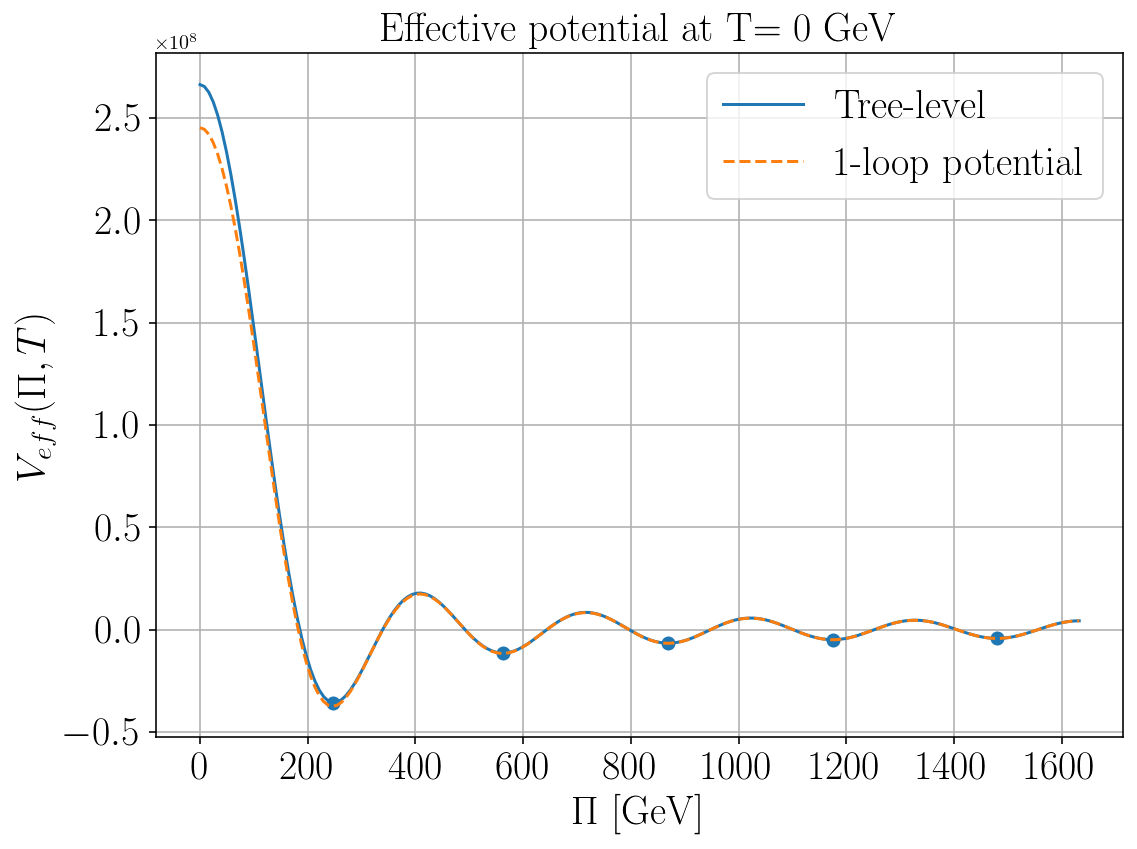

In [5]:
m=model1(Ngb=4, n=20)
#m.include_CW=True

#m.findVacua_list()
print("True vacuum are h=",m.vacua_list*m.f)
print("Confinement scale f=",m.f)
m.plot1()
m.plot2(0)

#plt.savefig('./PLOTS/case1_G1.pdf', dpi=300)

#X=[1e-20,v,100]
#bosons=m.boson_massSq( X, 0)
#fermions=m.fermion_massSq(X)
#m.V1(bosons,fermions)
#m.Vtot(0,0)
#m.V1_from_X(1e-20)
#misc.derivative(m.V1_from_X, x0=v, dx=1e-1, n=1)
#misc.derivative(m.V1_from_X, x0=v, dx=1e-1, n=2)
#misc.derivative(m.Vtot, x0=v,args=(0,), dx=1e-1, n=2)**.5
#bosons


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide


{'Ngb': 4,
 'n': 20,
 'Trestored': 257.286432160804,
 'Tc': 248.62759341273934,
 'phi_false': array(-0.04699898),
 'phi_true': array(192.77492119),
 'Tn': 246.78667853609252,
 'alpha': array(0.00114787),
 'beta': 94017.10569230524,
 'vw': array(0.17002243),
 'SNR': 8.002241535748598e-17}

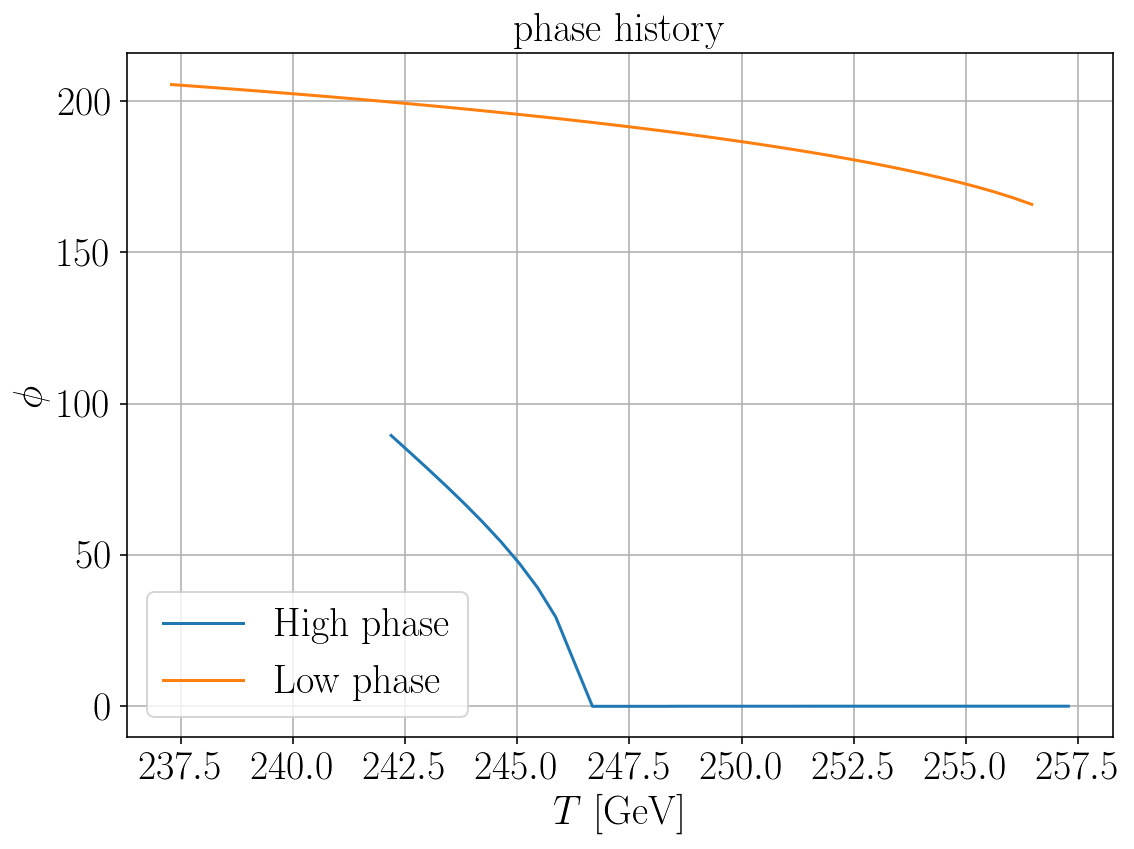

In [6]:
m.thermodynamics()

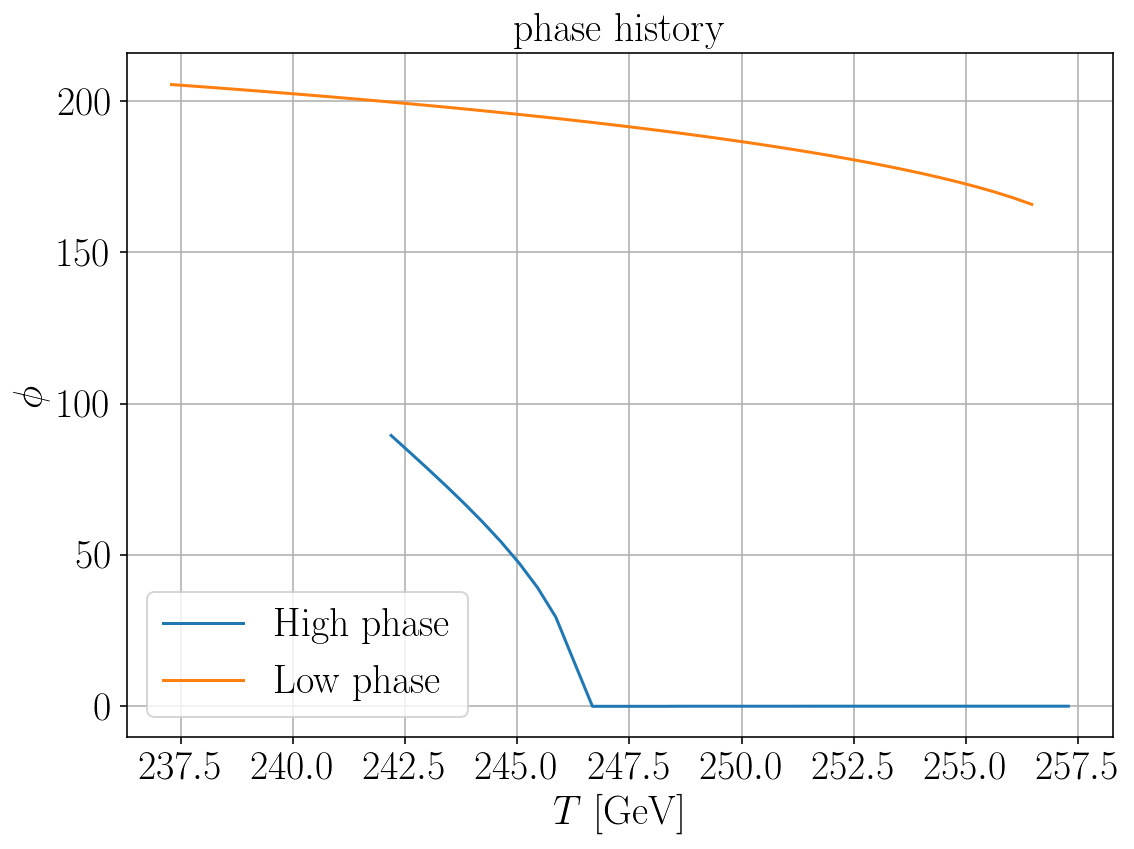

In [7]:
m.findTcritical()

In [8]:
phase_output=m.phases
phase0_T=interpolate.interp1d(phase_output["phase_0"]["T"], phase_output["phase_0"]["phi"])
phase1_T=interpolate.interp1d(phase_output["phase_1"]["T"], phase_output["phase_1"]["phi"])



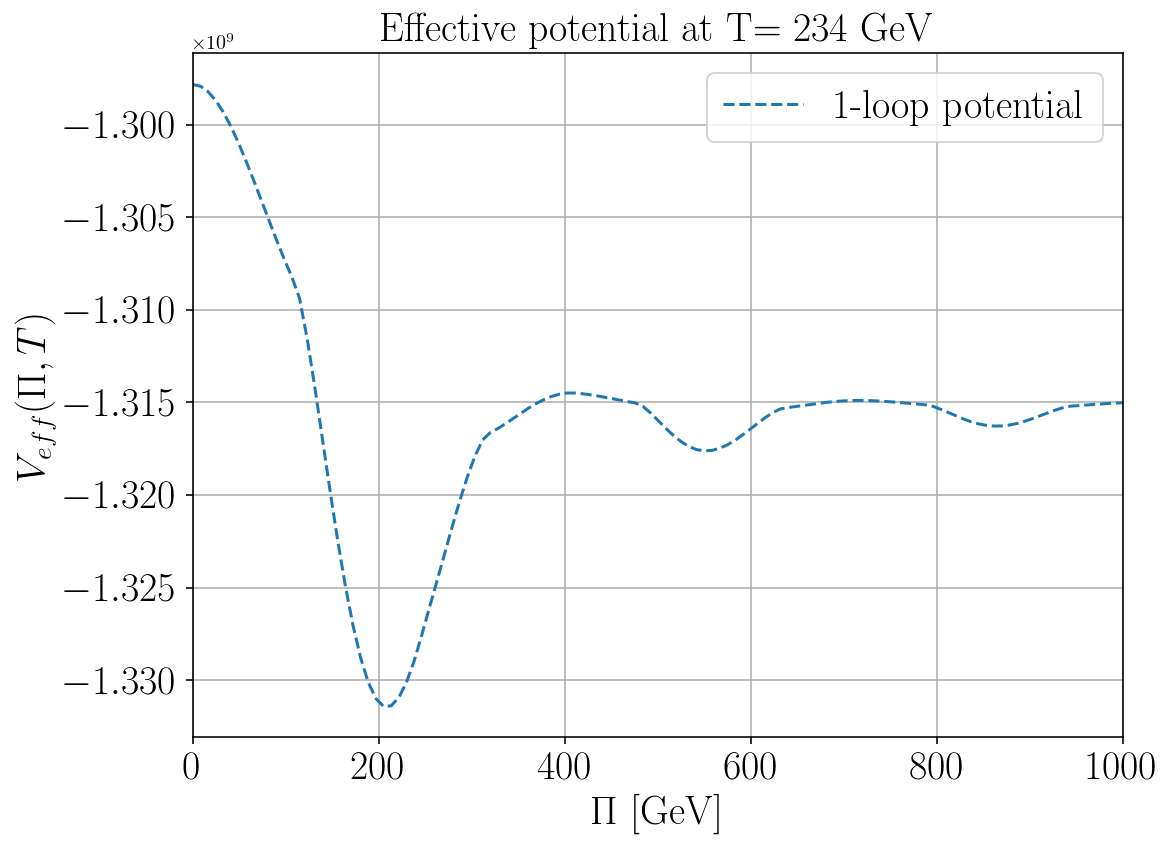

CPU times: user 318 ms, sys: 222 ms, total: 540 ms
Wall time: 2.2 s


In [22]:
%%time
Temp=m.Tc+40
Temp=234
m.plot2(Temp)

#min_list=m.findMinima(Temp)
#if len(min_list)>0:
#    plt.scatter(min_list,m.Vtot(min_list,Temp),c="b",marker="X")
plt.xlim(0,1000)
#plt.annotate(s='', xy=(phase1_T(Temp),m.Vtot(phase1_T(Temp),Temp)), xytext=(phase0_T(Temp),m.Vtot(phase0_T(Temp),Temp)), 
#             arrowprops=dict(arrowstyle='->',color="black",mutation_scale=15,linewidth=3))
plt.savefig('./PLOTS/BPPotentialT4.pdf', dpi=300)
plt.show()

In [9]:


m.nucleation(m.Tc-.0001)
        

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


{'phi_false': array(-0.01587657),
 'phi_true': array(195.31096279),
 'Tn': 245.4464107085207,
 'Gamma': 0.0,
 'S_3': 29991184.124344792,
 'Hubble1': 7.200111223052586e-27,
 'Hubble2': 1.3750551972124313e-35,
 'alpha': 0.001129236595539847,
 'vw': 0.0013004629727707872,
 'vJ': 0.6041289381647846}

In [10]:
Tmin=min(m.phases["phase_0"]["T"])
nucleation_list=[]
for temp in np.linspace(Tmin,m.Tc):
    try:
        nuc_output=m.nucleation(temp)
        if len(nuc_output)!=0:
            nucleation_list.append(nuc_output)
    except:
        continue
    
df_nuc=pd.DataFrame(nucleation_list).dropna()

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


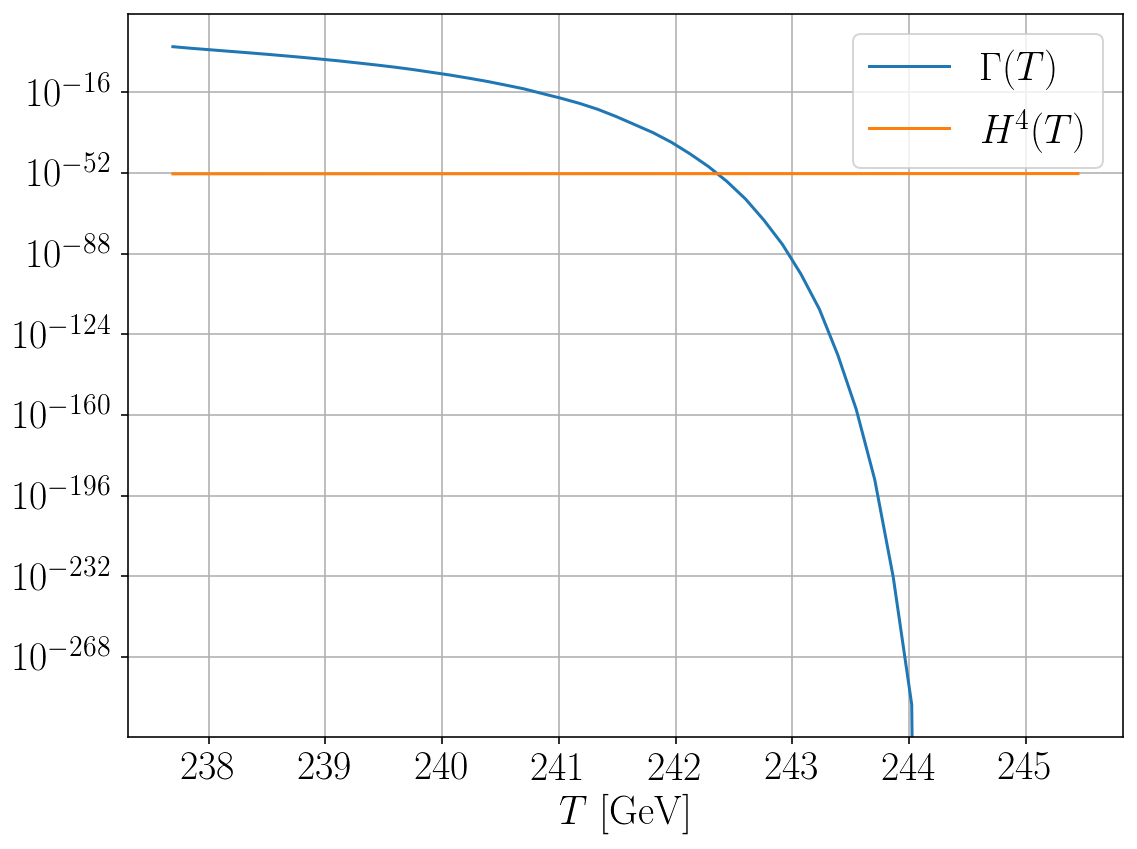

In [11]:
plt.plot(df_nuc["Tn"],df_nuc["Gamma"],label="$\Gamma(T)$")
plt.plot(df_nuc["Tn"],(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2,label="$H^4(T)$")
#plt.plot(df_nuc["Tn"],N_nuc(df_nuc["Tn"])+1)
plt.yscale("log")

plt.xlabel("$T$ [GeV]",size=label_size)
#plt.ylabel("$\Gamma/H^4$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend()
plt.legend(prop={'size': label_size})
#mytitle="Effective potential at T= "+str(T)+" GeV"
#plt.title(mytitle,size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/Rates_1.pdf', dpi=300)
plt.show()

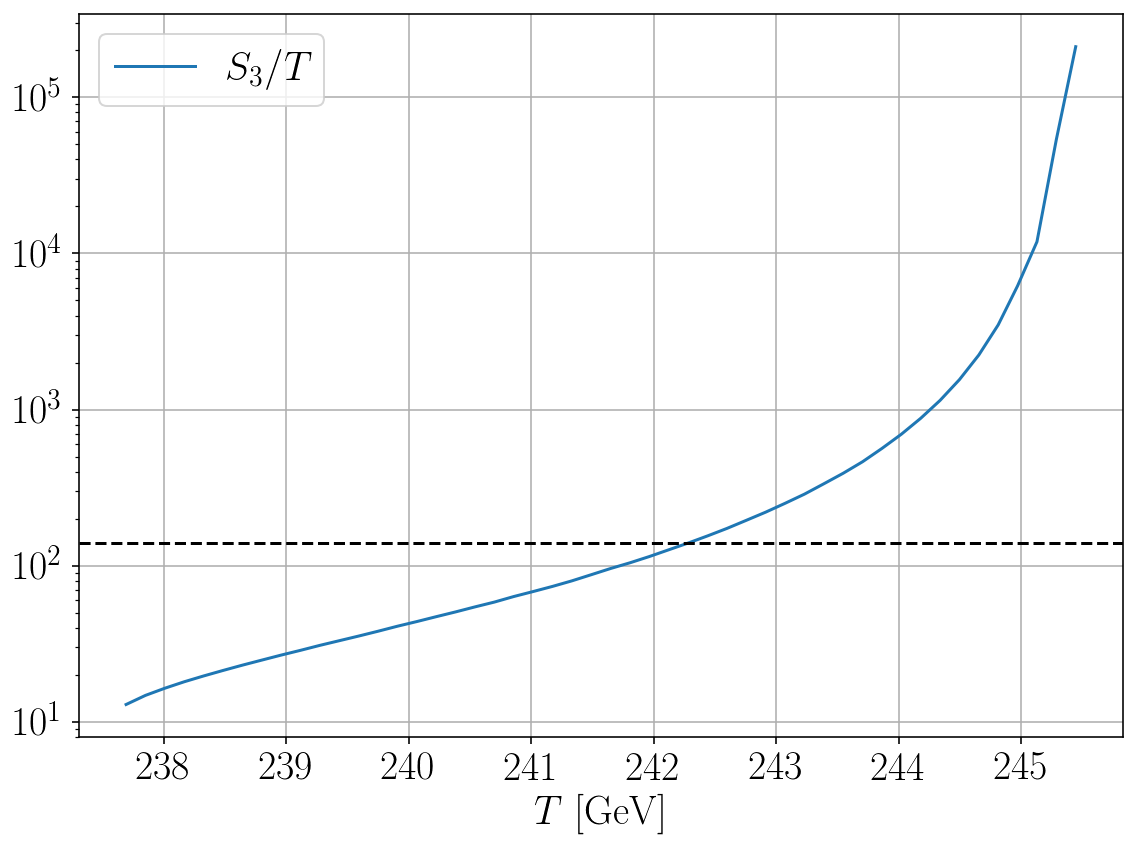

In [12]:

plt.plot(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"],label="$S_3/T$")
plt.yscale("log")
plt.xlabel("$T$ [GeV]",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend(prop={'size': label_size})
plt.axhline(y=140,c="k",linestyle="--",label="140")

plt.tight_layout()
plt.savefig('./PLOTS/Euclidean_action_1.pdf', dpi=300)
plt.show()

In [13]:



N_nuc=interpolate.interp1d(df_nuc["Tn"],(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2/df_nuc["Gamma"]-1)
Tnuc=optimize.root_scalar(N_nuc,bracket=(df_nuc["Tn"].min(),df_nuc["Tn"].max())).root

S_T_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"])
beta=Tnuc*misc.derivative(S_T_inter, x0=Tnuc, dx=1e-0, n=1)

alpha_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["alpha"])
vel_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["vw"])



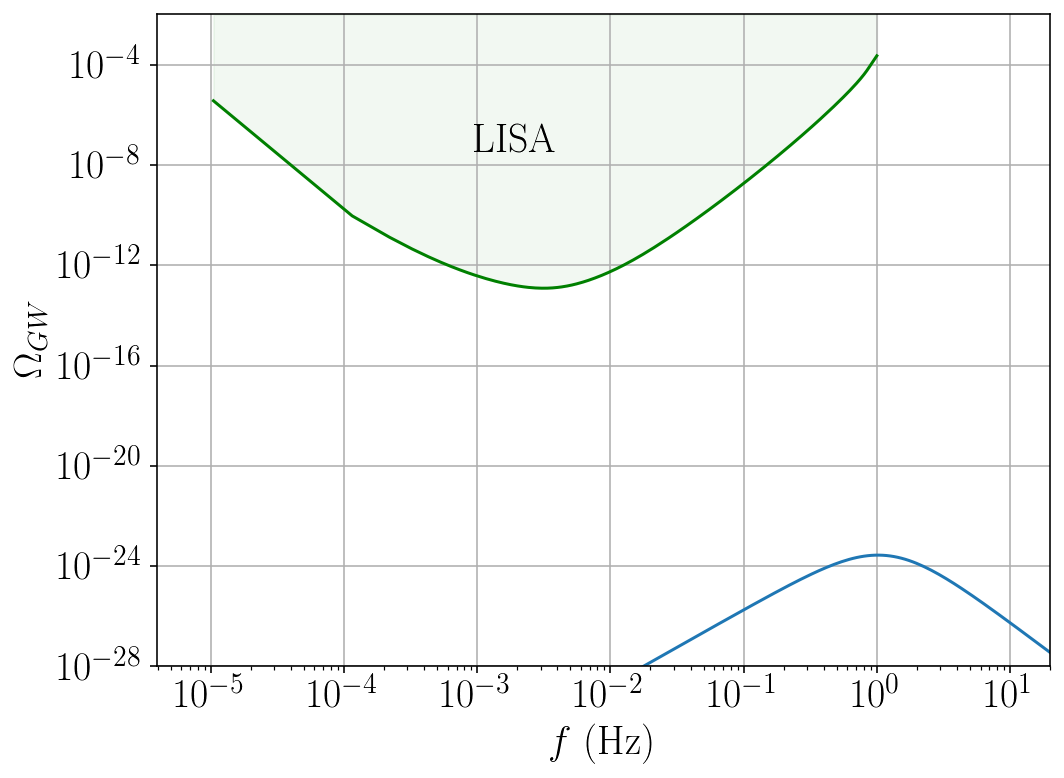

In [15]:
Temp,al,beta,vel=Tnuc,alpha_inter(Tnuc),beta,vel_inter(Temp)
my_signal=GW_signal(Temp,al,beta,vel)
SNR_signal=SNR_GW(my_signal)


plt.plot(my_signal[0],my_signal[1])
plt.plot(LISA_sens[::,0],LISA_sens[::,3],color="g")
plt.fill_between(LISA_sens[::,0],LISA_sens[::,3], 1e-2, alpha=0.05,color="g")

#plt.plot(LISA_curve.f,LISA_curve.Omega_lim,alpha=0.05,color="g")
plt.figtext(.4, .72, "LISA", fontsize=label_size)
plt.ylim(1e-28,)
plt.xlim(10**(-5.4),20)

plt.xlabel("$f$ (Hz)",size=label_size)
plt.ylabel("$\\Omega_{GW}$",size=label_size)
plt.xscale("log")
plt.yscale("log")  
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)


In [20]:
Tnuc,alpha_inter(Tnuc),beta,vel_inter(Temp)

(242.2825145939774, array(0.00123683), 27205.983692982834, array(0.21713025))

Best approximation is, v= 246.20001343541347 , mh= 125.09000361481519


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Best approximation is, v= 246.1999989260683 , mh= 125.08999803414632


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


Best approximation is, v= 246.2249383840196 , mh= 125.08925704930442


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


Best approximation is, v= 246.2000098572106 , mh= 125.0895343810404


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Best approximation is, v= 246.19998807424992 , mh= 125.09002310467187


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


Best approximation is, v= 246.20964485288982 , mh= 125.08868003344173


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


Best approximation is, v= 246.22501549578348 , mh= 125.09006759437217


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


Best approximation is, v= 246.17807937516847 , mh= 125.09149741989368


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


Best approximation is, v= 246.2190362558727 , mh= 125.09035067134982


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


Best approximation is, v= 246.183492579102 , mh= 125.09007973111602


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


Best approximation is, v= 246.1999951854013 , mh= 125.09000011213702


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


Best approximation is, v= 246.22187942153388 , mh= 125.09009497048802


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *

Best approximation is, v= 246.2038589790302 , mh= 125.09475948452098


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt


Best approximation is, v= 246.19069182681852 , mh= 125.08871010178281


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


Best approximation is, v= 246.21383463621055 , mh= 125.09084819186371


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *

Best approximation is, v= 246.2123868249917 , mh= 125.08951313331406


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *

Best approximation is, v= 246.2080869860398 , mh= 125.09000079099218


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *

CPU times: user 40min 4s, sys: 17 s, total: 40min 21s
Wall time: 40min 16s


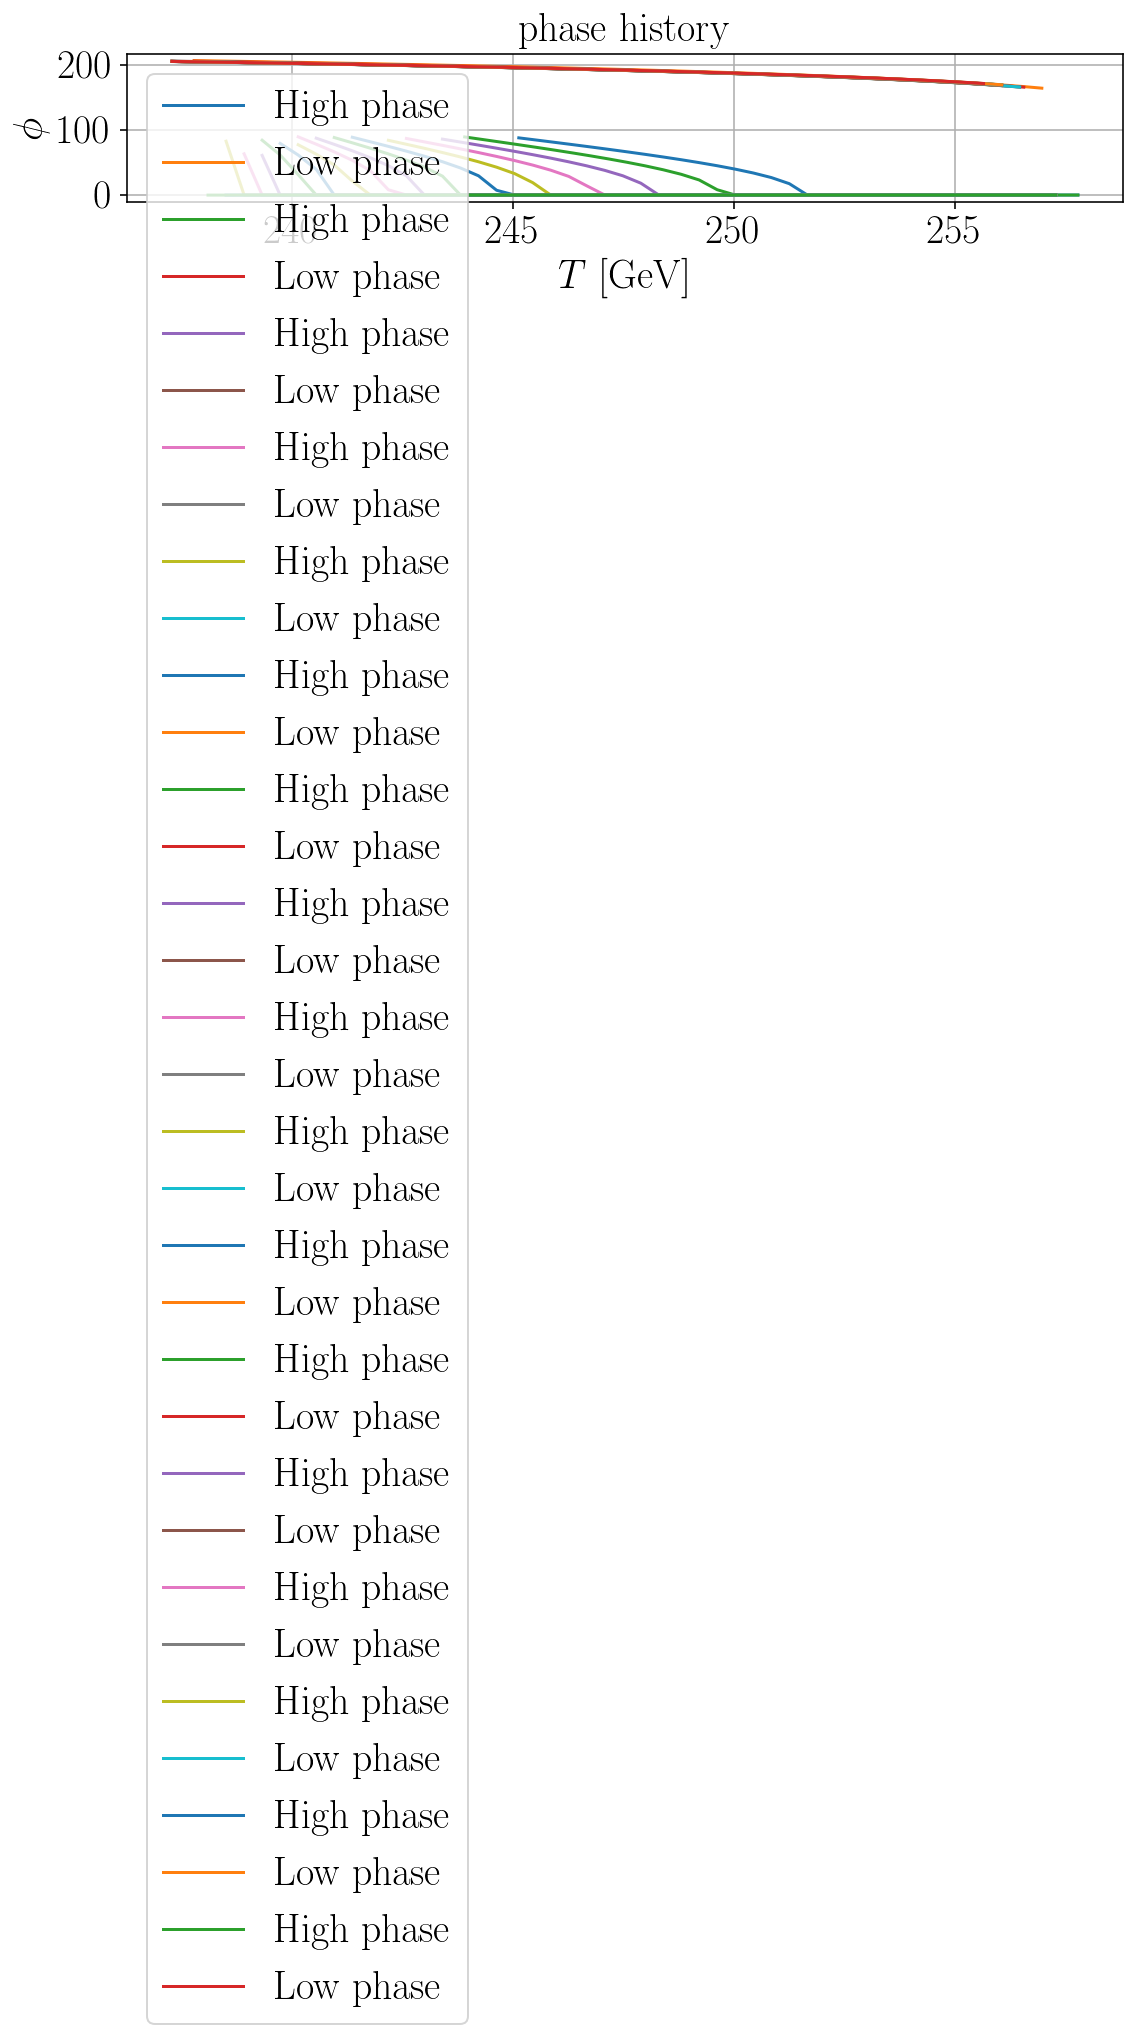

In [15]:
%%time
n_range=np.arange(10,60,3)
all_results=[]
for n_val in n_range:
    try:
        m=model1(Ngb=4, n=n_val)
        dict_out=m.thermodynamics()
        all_results.append(dict_out)
    except:
        continue

In [21]:
df_out.columns

Index(['Ngb', 'n', 'Trestored', 'Tc', 'phi_false', 'phi_true', 'Tn', 'alpha',
       'beta', 'vw', 'SNR'],
      dtype='object')

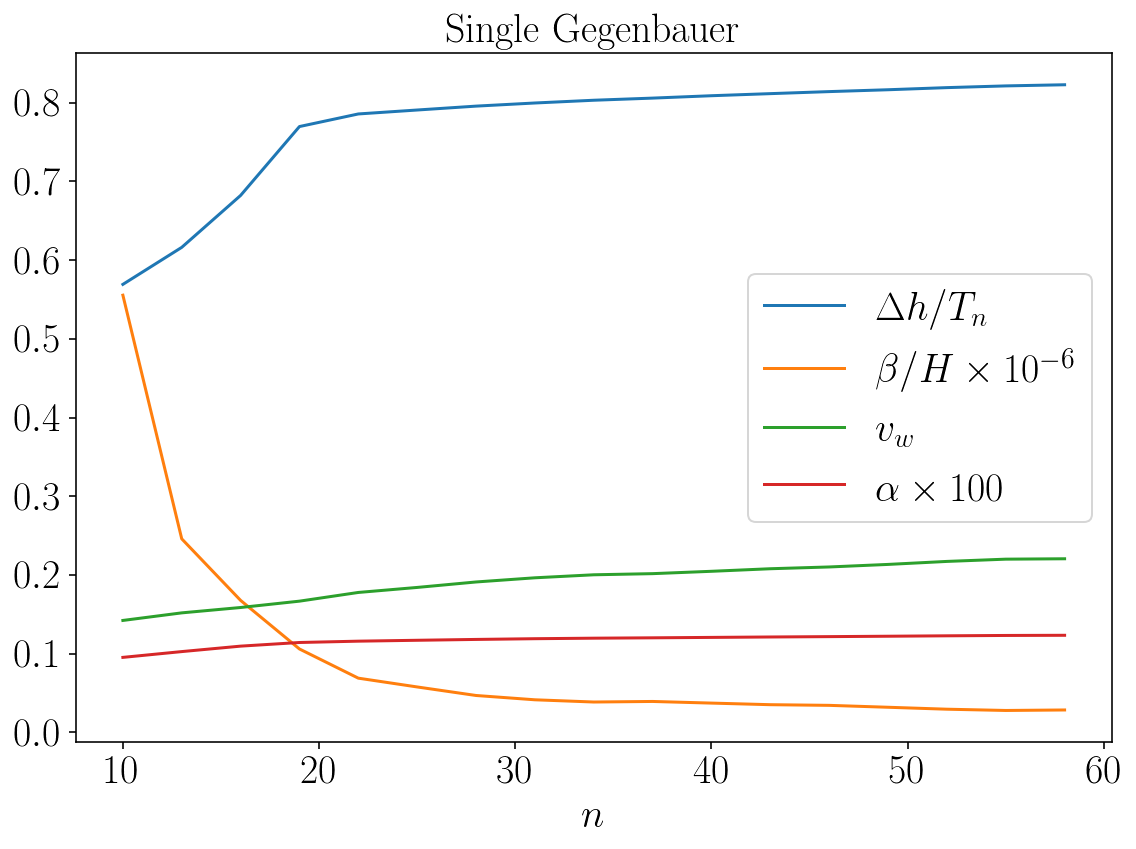

In [55]:
df_out=pd.read_csv("./Gegenbauer_thermodynamics.csv",index_col=[0])


plt.plot(df_out.n,abs(df_out.phi_true-df_out.phi_false)/df_out.Tn,label="$\Delta h/T_n$")
plt.plot(df_out.n,df_out.beta/1e6,label="$\\beta/H \\times 10^{-6}$")
plt.plot(df_out.n,df_out.vw,label="$v_w$")
plt.plot(df_out.n,df_out.alpha*100,label="$\\alpha \\times 100$")
#plt.ylim(1e-28,)
#plt.xlim(10**(-5.4),20)

plt.xlabel("$n$ ",size=label_size)
#plt.ylabel("$\\Omega_{GW}$",size=label_size)
#plt.xscale("log")
#plt.yscale("log")  
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.legend(loc="right",prop={'size': label_size})
plt.title("Single Gegenbauer",size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/Gegenbauer_thermodynamics.pdf', dpi=300)
plt.show()

In [13]:
###This for loop adds the chhh and epsilon 
# df_out=pd.read_csv("./Gegenbauer_thermodynamics.csv",index_col=[0])
# 
# output=[]
# for nval in df_out.n.values:
#     m=model1(Ngb=4, n=nval)
#     m.Higgs_trilinear()
#     chhh=m.chhh
#     epsilon=m.const/m.f**4
#     output.append([chhh,epsilon])
# 
# df_out["chhh_loop"]=np.array(output).T[0]
# df_out["epsilon"]=np.array(output).T[1]
# 
# df_out.to_csv("./Gegenbauer_thermodynamics_2.csv")